<AxesSubplot:>

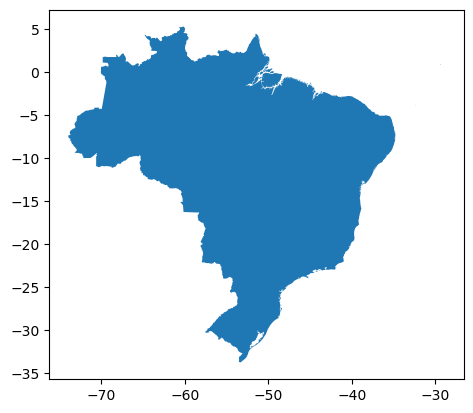

In [1]:
import geopandas as gpd
import pandas as pd

# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
df = gpd.read_file('../resources/ne_10m_admin_0_countries.shp')

brazil = df.loc[df['ADMIN'] == 'Brazil']
brazil.plot()

In [2]:
import rasterio

topography_file = rasterio.open('../resources/ETOPO1_Bed_g_geotiff.tif')

In [3]:
from rasterio import mask as msk 
from shapely.geometry import mapping

clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=0)

In [4]:
import numpy as np

print(np.amin(clipped_array))
print(np.amax(clipped_array))

-2802
2608


In [5]:
clipped_array, clipped_transform = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=-28)

In [6]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm
import matplotlib.pyplot as plt

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 2002))
background_colour = np.array([0.0, 0.0, 0.0, 0.0])
colors_land[:1, :] = background_colour
newcmp_topo = ListedColormap(colors_land)

bounds = np.arange(-28, 1975, 1)
norm_topo = BoundaryNorm(bounds, newcmp_topo.N)

In [ ]:
rows, cols = clipped_array[0].shape
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

# Calculate the real-world coordinates
xs, ys = rasterio.transform.xy(clipped_transform, row_indices.flatten(), col_indices.flatten())

# Create a DataFrame
df = pd.DataFrame({
    'X': xs,
    'Y': ys,
    'Value': clipped_array[0].flatten()
})

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

print(gdf)

In [ ]:
gdf.plot(column='Value', s=2, cmap=newcmp_topo, norm=norm_topo, edgecolors='none')

In [ ]:
import numpy as np
from osgeo import gdal, ogr
from osgeo import osr
from rasterio.transform import from_origin

gdal_transform = (clipped_transform.c, clipped_transform.a, clipped_transform.b,
                  clipped_transform.f, clipped_transform.d, clipped_transform.e)

# Create an in-memory raster
mem_drv_raster = gdal.GetDriverByName('MEM')
mem_raster = mem_drv_raster.Create('', clipped_array[0].shape[1], clipped_array[0].shape[0], 1, gdal.GDT_Int32)

# Set the geotransform
mem_raster.SetGeoTransform(gdal_transform)

# Write the data
mem_raster.GetRasterBand(1).WriteArray(clipped_array[0])

# Create an in-memory vector layer
mem_drv_vector = ogr.GetDriverByName('Memory')
mem_vector = mem_drv_vector.CreateDataSource('out')
mem_layer = mem_vector.CreateLayer('polygonized_raster', geom_type=ogr.wkbPolygon)

# Add a new field to store raster values
new_field = ogr.FieldDefn('DN', ogr.OFTInteger)
mem_layer.CreateField(new_field)

# Polygonize the raster to the in-memory vector layer
gdal.Polygonize(mem_raster.GetRasterBand(1), None, mem_layer, 0, [], callback=None)


In [ ]:
from shapely.geometry import Polygon

geoms = []
vals = []

# Access the polygons
for feature in mem_layer:
    geom = feature.GetGeometryRef()
    
    # Extract the coordinates from the geometry
    ring = geom.GetGeometryRef(0)
    coordinates = []
    for i in range(ring.GetPointCount()):
        x, y = ring.GetX(i), ring.GetY(i)
        coordinates.append((x, y))
        
    geoms.append(Polygon(coordinates))
    vals.append(feature.GetField('DN'))

gdf = gpd.GeoDataFrame(pd.DataFrame({'vals': vals}), crs='EPSG:4326', geometry=geoms)

print(gdf)

In [ ]:
gdf.plot(column='vals', cmap=newcmp_topo, norm=norm_topo)

In [ ]:
from osgeo import ogr


# Generate contours directly in memory
mem_ds = ogr.GetDriverByName('Memory').CreateDataSource('out')
contour_lyr = mem_ds.CreateLayer('contour', geom_type=ogr.wkbLineString25D)

# Define fields of id and elev
field_def = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_lyr.CreateField(field_def)
field_def = ogr.FieldDefn("elev", ogr.OFTReal)
contour_lyr.CreateField(field_def)

# Generate contours
gdal.ContourGenerate(mem_raster.GetRasterBand(1), 50, -11, [], 0, 0, contour_lyr, 0, 1)

gdal.Unlink('/vsimem/temp.vrt')
gdal.Unlink('/vsimem/mosaic.tif')

In [ ]:
from shapely.geometry import LineString

lines = [LineString(np.array(contour.GetGeometryRef().GetPoints())) for contour in contour_lyr]
elev = [contour.GetField('elev') for contour in contour_lyr]
gdf = gpd.GeoDataFrame(pd.DataFrame({'elev': elev}), crs="EPSG:4326", geometry=lines)
print(gdf)

In [ ]:
gdf.plot(lw=0.1, column='elev', cmap=newcmp_topo, norm=norm_topo)

In [ ]:
from rasterio.plot import show


fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

show(clipped_array, ax=ax, transform=clipped_transform, cmap=newcmp_topo, norm=norm_topo)
gdf.plot(lw=0.05, ax=ax, column='elev', color='black')

plt.savefig("test.png", dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
samerica_rivers = gpd.read_file("../resources/rivers.geojson")

leftSpan = np.amax(samerica_rivers['DIST_UP_KM']) - np.amin(samerica_rivers['DIST_UP_KM'])
rightSpan = 1 - 0.1
valueScaled = (samerica_rivers['DIST_UP_KM'] - np.amin(samerica_rivers['DIST_UP_KM'])) / leftSpan
samerica_rivers['LW_DIST_UP_KM'] = 0.1 + (valueScaled * rightSpan)


In [ ]:
from rasterio.plot import show

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

show(clipped_array, ax=ax, transform=clipped_transform, cmap=newcmp_topo, norm=norm_topo)
gdf.plot(lw=0.05, ax=ax, column='elev', color='black')
samerica_rivers.plot(ax=ax, edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'])

plt.show()